In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import *
from tqdm import tqdm
from numba import njit
import pandas as pd

def add_periodic_boundaries(arr):
    # takes an (n-2, m-2) array and returns (n, m) array
    rows, cols = arr.shape
    output = np.zeros((rows+2, cols+2), dtype=arr.dtype)

    # Fill the output array with the periodic boundaries
    output[1:-1, 1:-1] = arr # center
    output[0:1, 1:-1] = arr[-1:,:] # first row
    output[-1:, 1:-1] = arr[0:1,:] # last row
    output[1:-1, 0:1] = arr[:,-1:] # first column
    output[1:-1, -1:] = arr[:,0:1] # last column

    return output

plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100
plt.set_cmap("binary_r")

<Figure size 1400x800 with 0 Axes>

In [4]:
def read_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return lines

def find_index(lst):
    return int(lst[-2])

def find_name(lst):
    return lst[-1]

def find_edges(lst):
    # Split each string in the list by whitespace, convert to integers, and store in a new list
    processed_lst = [list(map(int, item.strip().split())) for item in lst]
    return np.array(processed_lst)

yeast = read_file('LAB3-data/YeastS.net') # list of strings, 2361 vertices
yeast = yeast[12:]
N_vertices = 2361 

vertices = np.array([find_index(yeast[i].split(" ")) for i in range(N_vertices)]) # equivalent to np.arange(1, 2361+1)
names = [find_name(yeast[i].split(" ")) for i in range(N_vertices)] # optional names for the vertices

edges = find_edges(yeast[N_vertices+1:]) - 1 # egdes of the graph, subtracting 1 so the indices starts with 0
N_edges = len(edges)

@njit
def construct_adj_matrix(edges, 
                         A = np.zeros([N_edges, N_edges], dtype=int)):
    col1, col2 = edges.T
    for i in col1:
        for j in col2:
            A[i,j] = 1          
    return A

# Constructing the adjacency matrix
adj_matrix = construct_adj_matrix(edges)


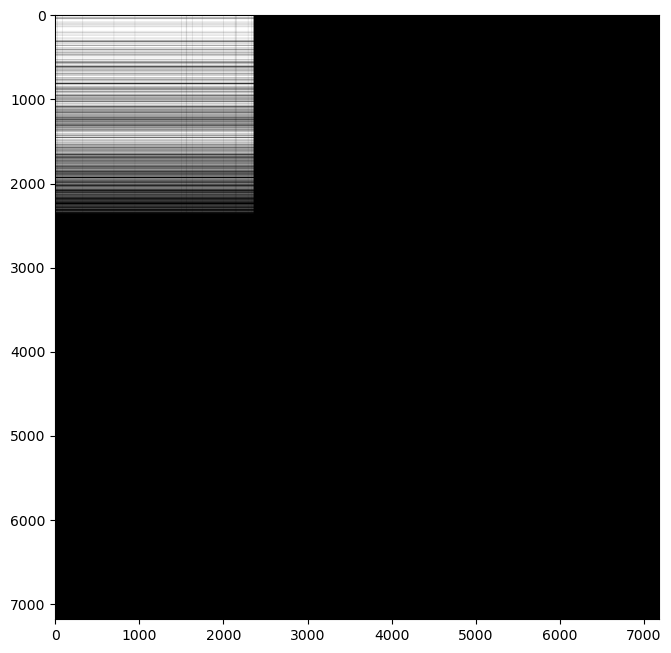

In [5]:
plt.imshow(adj_matrix)

In [81]:
vertices

array([   1,    2,    3, ..., 2359, 2360, 2361])